# Crime Rhythm Maps Example

This notebook demonstrates how to generate  rhythm maps for crime data, a form of heat map with two time dimensions. 

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Region Crime Incidents 2007 - 2013
`sandag.gov-crime-2007e2013-2.1.2` Last Update: 2020-11-24T04:23:58

_Processed crime incidents for San Diego county, 2007-2013. Of our crime datasets, this one is most useful for analysis._

Processed crime incidents, based on data supplied by SANDAG.

Important:

  * See Caveats for limitations and warnings regarding this data. 
  * Use of this data is subject to multiple terms and conditions. See Terms for details. 

This dataset includes geocoded crime incidents from 1 Jan 2007 to 31 March 2013 that were returned by SANDAG for Public Records request 12-075. 


Asr\_zone Codes
===============

The integer values in the asr\_zone field are taken directly from the [SANGIS parcel data](http://rdw.sandag.org/file_store/Parcel/Parcels.pdf). These values are: 

	╔════╦═════════════════════════════════╗
	║ -1 ║ Unset                           ║
	║  0 ║ Unzoned                         ║
	║  1 ║ Single family residential (R-1) ║
	║  2 ║ Minor multiple (R-2)            ║
	║  3 ║ Restricted multiple (R-3)       ║
	║  4 ║ Multiple residential (R-4)      ║
	║  5 ║ Restricted commercial           ║
	║  6 ║ Commercial                      ║
	║  7 ║ Industrial (M zone)             ║
	║  8 ║ Agricultural                    ║
	║  9 ║ Special and/or misc.            ║
	╚════╩═════════════════════════════════╝				



Addresses and Geocoding
=======================
SANDAG returns the position of incidents as a block address, and occasionally as an intersection. Block addresses are the original address of the incident, with the last two digits set to '00'. 

Before geocoding, all of the original block addresses are normalized to be more consistent and to remove different versions of the same address. There are a few transformations performed on the address, including:

  * Converting street types synonyms like 'Avenue', 'Avenu' and 'ave.' to standard abbreviations like 'ave.'
  * Converting street directions ( 'West main Street' ) to abbreviations like 'W Main st'

Many geocoders are designed to work with mailable addresses, and block addresses are not real postal addresses. This data is geocoded with custom code that uses the SANGIS streets database, matching the block addresses to a street segment. This produces more sensible results, because the crime is attributed to an entire block, rather than to an arbitrary point on the block. However, with the crime is represented as a point, it will appear at the location of the center of the street segment, usually in the middle of the block. 

This means that all of the incidents on a block will appear at a single location. In most GIS programs, it is difficult to see that there are actually many points in one place. Be aware that each point you see may actually be dozens of incidents. 

The files that SANDAG returned included 1,008,524 incident records, and 953,824 records were geocoded (95%). The 'gctype' field has a value of NONE when the  record was not geocoded, and any field that depends on a locations, such as x, y, lon, lat, segment_id, community, and others, will have default values. 

Caveats
=======

As with most crime data, there are many issues, limitations and problems that users must be aware of to avoid making incorrect conclusions. 

*Crime incident data is inherently problematic.* Crime incident reports are collected by busy officers in stressful situations who are trying to describe complex situations with rigid categories. Virtually every point of the data collection process has multiple opportunities for errors and few opportunities for correction after the fact. Analysts must consider the difficulties of collecting crime data when assessing the validity of any conclusions. 

*Data is collected by 19 different agencies.* While the data is all sourced from SANDAG, it originates with 19 different police departments. These departments may have different policies that can result in different categorizations for the same crime, and they m

In [4]:
incidents = pkg.resource('incidents').geoframe()

incidents['doy'] = incidents.datetime.dt.dayofyear
incidents['dummy'] = 1

In [5]:
# Make Day of week a categorical with proper names, and ordered, so it will sort correctly. 
dow = ['M','T','W','Th','F','Sa','Su']
incidents['dow'] = pd.Categorical(incidents.dow.replace(dict(zip(range(len(dow)),dow))), categories=dow, ordered=True)


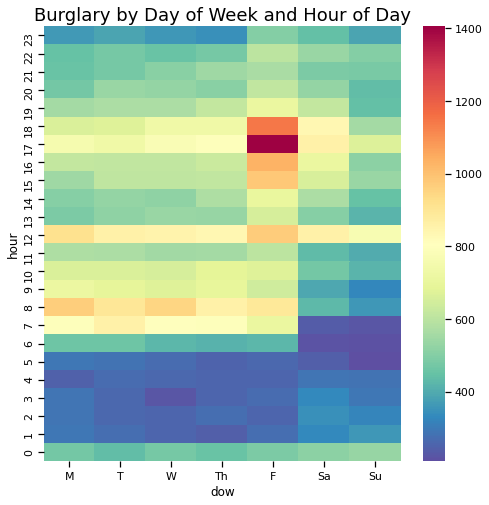

In [6]:
def rhymap(df, x_col, y_col, categories, title=None):
    """Make a rhythm map from two time variables"""
    
    
    if not isinstance(categories, (list, tuple)):
        categories = [categories]
    
    t=df[df.category.isin(categories)].groupby([y_col, x_col]).dummy.count().unstack().sort_index(ascending=False)

    fig, ax = plt.subplots(1, figsize=(8,8))

    if title is not None:
        ax.set_title(title, fontsize=18)
     
    
    sns.heatmap(t, cmap="Spectral_r")
    
rhymap(incidents, 'dow', 'hour', 'BURGLARY', "Burglary by Day of Week and Hour of Day")

In [7]:
list(sorted(incidents.community.unique()))

['Balboa Park',
 'Barrio Logan',
 'Black Mountain Ranch',
 'Carmel Mountain Ranch',
 'Carmel Valley',
 'Clairemont Mesa',
 'College Area',
 'Del Mar Mesa',
 'Downtown',
 'East Elliott',
 'Encanto Neighborhoods,Southeastern',
 'Fairbanks Ranch Country Club',
 'Greater Golden Hill',
 'Greater North Park',
 'Kearny Mesa',
 'La Jolla',
 'Linda Vista',
 'Los Penasquitos Canyon',
 'Mid-City:City Heights',
 'Mid-City:Eastern Area',
 'Mid-City:Kensington-Talmadge',
 'Mid-City:Normal Heights',
 'Midway-Pacific Highway',
 'Military Facilities',
 'Mira Mesa',
 'Miramar Ranch North',
 'Mission Bay Park',
 'Mission Beach',
 'Mission Valley',
 'NONE',
 'Navajo',
 'Ncfua Subarea Ii',
 'Ocean Beach',
 'Old Town San Diego',
 'Otay Mesa',
 'Otay Mesa-Nestor',
 'Pacific Beach',
 'Pacific Highlands Ranch',
 'Peninsula',
 'Rancho Bernardo',
 'Rancho Encantada',
 'Rancho Penasquitos',
 'Reserve',
 'Sabre Springs',
 'San Pasqual',
 'San Ysidro',
 'Scripps Miramar Ranch',
 'Serra Mesa',
 'Skyline-Paradise Hil

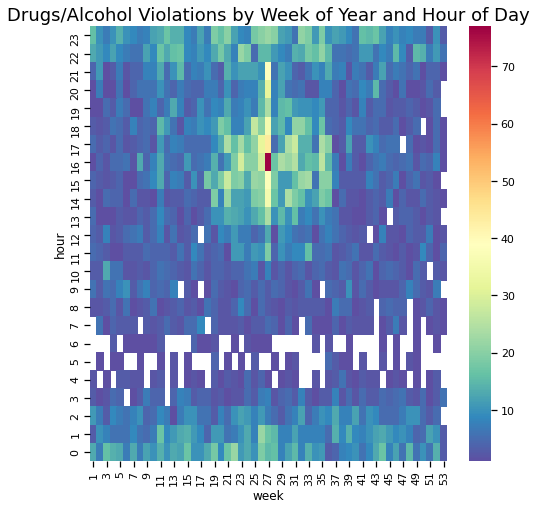

In [8]:
rhymap(incidents[incidents.community=='Pacific Beach'], 'week', 'hour', 'DRUGS/ALCOHOL VIOLATIONS',
       "Drugs/Alcohol Violations by Week of Year and Hour of Day")

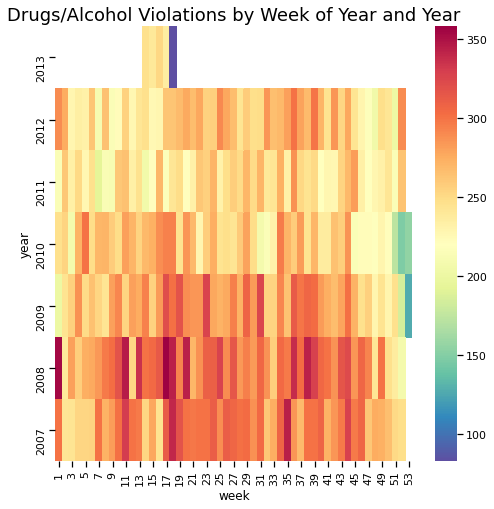

In [9]:
rhymap(incidents, 'week', 'year', 'ASSAULT',
       "Drugs/Alcohol Violations by Week of Year and Year")

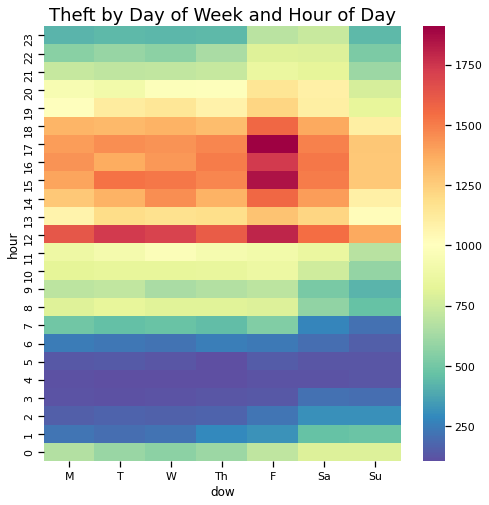

In [11]:
rhymap(incidents, 'dow', 'hour', 'THEFT/LARCENY', "Theft by Day of Week and Hour of Day")

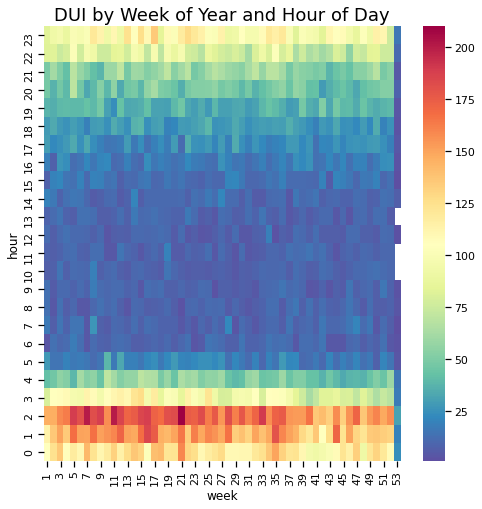

In [12]:
rhymap(incidents, 'week', 'hour', 'DUI', "DUI by Week of Year and Hour of Day")